In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import seaborn as sns
import math
import random
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

In [84]:
with open('../datasets/washing_machine_labels.txt', 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line)

Energy Rating Data Dictionary for Clothes Washers (labelled) as at May 2015



Column - Column Identifier - Description

ApplStandard - Registration.regulatory_standard - This is the legal standard to which the appliance must comply

Brand - Model.brand_name - This is the manufacturers brand

Cap - rated_load_capacity - This is the rated capacity of the appliance in half kilogram increments only.

CEC Cold - cec_cold - This is the current Comparative Energy Consumption for the product on cold wash expressed as kilowatt hours per years.

CEC_ - cec_warm_wash - This is the current Comparative Energy Consumption for the product on warm wash expressed as kilowatt hours per years.

Cold Prog - cold_prog - Name of program used in cold wash tests

Cold Wat Cons - c_wtrcnsmp - Average cold water consumption in whole litres

Combination - is_combination_washer_dryer - The appliance may be a combination washer/dryer

Control - control - The appliance may have a control a timer or is autosensing


In [85]:
data = pd.read_csv('../datasets/washing_machine.csv')
ranges = {}
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 48 columns):
ApplStandard                790 non-null object
Brand                       790 non-null object
Cap                         790 non-null float64
CEC Cold                    273 non-null float64
CEC_                        790 non-null int64
Cold Prog                   253 non-null object
Cold Wat Cons               210 non-null float64
Combination                 783 non-null object
Conn_Mode                   790 non-null object
Country                     790 non-null object
delayStartMode              782 non-null object
Depth                       415 non-null float64
DetergentType               783 non-null object
Height                      415 non-null float64
Hot Wat Cons                210 non-null float64
internal_heater             782 non-null object
Loading                     783 non-null object
MachineAction               292 non-null object
Model No                  

In [86]:
# Let us first find see the features which we might have to drop
print(data.columns.values, '\n')

# As we can see here, Grand Date and Old Star Rating are entirely empty so we can drop them
print(data.isnull().sum(), '\n')

# For each of these features, more than 97% of the values are the same, we can drop these as well
print(pd.value_counts(data['N-Standard']), '\n')
print(pd.value_counts(data['Product Class']), '\n')
print(pd.value_counts(data['SubmitStatus']), '\n')
print(pd.value_counts(data['Availability Status']), '\n')
print(data['Tot Wat Cons'].value_counts(),'\n')

# Since Cold Prog is barely informative without a proper convention, we can drop it,
# Since Hot Wat Cons and Cold Water (L) has more than 70% values missing, we drop that as well
columns = ['Cold Prog', 'Family Name', 'Tot Wat Cons', 'Model No', 'WEI', 'Hot Water (L)', 'postProgenergy', 'New SRI', 'Registration Number', 'MachineAction', 'Hot Wat Cons', 'Test Prog Time', 'Cold Water (L)', 'N-Standard', 'Sold_in', 'Submit_ID', 'GrandDate', 'SubmitStatus', 'Product Class', 'Product Website', 'Star Rating (old)', 'Star Image Large', 'ExpDate', 'Star Image Small', 'Availability Status', 'Representative Brand URL']
data.drop(columns, axis=1, inplace=True)

['ApplStandard' 'Brand' 'Cap' 'CEC Cold' 'CEC_' 'Cold Prog'
 'Cold Wat Cons' 'Combination' 'Conn_Mode' 'Country' 'delayStartMode'
 'Depth' 'DetergentType' 'Height' 'Hot Wat Cons' 'internal_heater'
 'Loading' 'MachineAction' 'Model No' 'Family Name' 'N-Standard' 'New SRI'
 'New Star' 'postProgenergy' 'powerConsMode' 'Prog Name' 'Sold_in'
 'standbyPowerUsage' 'Submit_ID' 'SubmitStatus' 'Test Prog Time'
 'Tot Wat Cons' 'Type' 'WEI' 'Width' 'ExpDate' 'GrandDate' 'Product Class'
 'Availability Status' 'Product Website' 'Representative Brand URL'
 'Program Time' 'Hot Water (L)' 'Cold Water (L)' 'Star Rating (old)'
 'Star Image Large' 'Star Image Small' 'Registration Number'] 

ApplStandard                  0
Brand                         0
Cap                           0
CEC Cold                    517
CEC_                          0
Cold Prog                   537
Cold Wat Cons               580
Combination                   7
Conn_Mode                     0
Country                       0


In [87]:
print(data.info())
data.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 22 columns):
ApplStandard         790 non-null object
Brand                790 non-null object
Cap                  790 non-null float64
CEC Cold             273 non-null float64
CEC_                 790 non-null int64
Cold Wat Cons        210 non-null float64
Combination          783 non-null object
Conn_Mode            790 non-null object
Country              790 non-null object
delayStartMode       782 non-null object
Depth                415 non-null float64
DetergentType        783 non-null object
Height               415 non-null float64
internal_heater      782 non-null object
Loading              783 non-null object
New Star             790 non-null float64
powerConsMode        782 non-null float64
Prog Name            789 non-null object
standbyPowerUsage    753 non-null float64
Type                 790 non-null object
Width                415 non-null float64
Program Time         790 n

,ApplStandard,Brand,Cap,CEC Cold,CEC_,Cold Wat Cons,Combination,Conn_Mode,Country,delayStartMode,...,Height,internal_heater,Loading,New Star,powerConsMode,Prog Name,standbyPowerUsage,Type,Width,Program Time
0,AS/NZS 2040.2:2000 (Legacy),Haier,5.0,90.0,480,107.47,NaN,Dual,China,NaN,...,NaN,NaN,Top,1.5,NaN,"Warm/cold, Large, Normal wash",NaN,Non-Drum,NaN,60.0
1,AS/NZS 2040.2:2000 (Legacy),INDESIT,5.5,230.0,240,75.00,NaN,Dual,Italy,NaN,...,NaN,NaN,Front,3.5,NaN,"Cotton No 4, 40C",NaN,Drum,NaN,90.0
2,AS/NZS 2040.2:2000 (Legacy),INDESIT,6.0,266.0,277,54.00,NaN,Dual,Italy,NaN,...,NaN,NaN,Front,3.5,NaN,"Cotton No3, 40 C",NaN,Drum,NaN,145.0
3,AS/NZS 2040.2:2000 (Legacy),INDESIT,6.0,133.0,327,57.00,NaN,Dual,Italy,NaN,...,NaN,NaN,Front,3.0,NaN,"No 2, 40 C",NaN,Drum,NaN,120.0


In [88]:
# Fill up missing value columns
missing_values_columns = [column for column in data.columns.values if data[column].isnull().sum()>0]
print(missing_values_columns)

['CEC Cold', 'Cold Wat Cons', 'Combination', 'delayStartMode', 'Depth', 'DetergentType', 'Height', 'internal_heater', 'Loading', 'powerConsMode', 'Prog Name', 'standbyPowerUsage', 'Width']


In [89]:
# Firstly we shall combine Brand and Country into a single column
Brand_Country = []
for index, row in data.iterrows():
    if len(row['Country'])>1: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1] + row['Country'][1][:1]).upper())
    else: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1]).upper())
data['Brand_Country'] = Brand_Country
data['Brand_Country']

0      HACH
1      INIT
2      INIT
3      INIT
4      SMCH
5      SMCH
6      MAIT
7      CAIT
8      ASSW
9      ASSW
10     ASSW
11     ASSW
12     WHIN
13     WHIN
14     WHIN
15     WHIN
16     EUCH
17     BRCH
18     BETU
19     EUCH
20     ARIT
21     ARIT
22     ARIT
23     INIT
24     INIT
25     INIT
26     EUCH
27     PATA
28     PATA
29     PATA
       ... 
760    HECH
761    KOCH
762    KOCH
763    KOCH
764    KOCH
765    OMCH
766    HACH
767    LGVI
768    LGVI
769    LGVI
770    LGVI
771    LGVI
772    LGVI
773    LGVI
774    HACH
775    LGVI
776    PACH
777    SMCH
778    ARPO
779    MIGE
780    MIGE
781    INCH
782    SMCH
783    SMCH
784    EVCH
785    LGVI
786    LGVI
787    LGVI
788    LGVI
789    LECH
Name: Brand_Country, Length: 790, dtype: object

mode of cec_cold -  150.0
0      47
150    11
90     10
195     9
106     9
94      8
115     8
84      8
188     8
127     8
77      7
70      7
216     7
128     7
95      7
130     7
190     7
133     7
26      7
163     7
129     6
119     6
184     6
153     6
166     6
102     6
101     6
173     6
93      6
86      6
       ..
25      1
282     1
141     1
138     1
35      1
137     1
169     1
192     1
171     1
235     1
266     1
197     1
218     1
79      1
82      1
220     1
63      1
62      1
89      1
230     1
176     1
204     1
202     1
49      1
48      1
200     1
109     1
199     1
212     1
876     1
Name: CEC Cold, Length: 206, dtype: int64


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


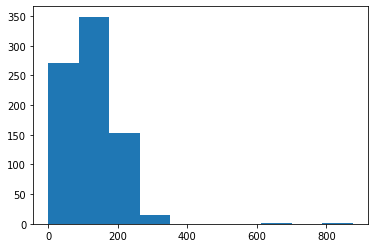

0    226
1    198
2    192
3    174
Name: CEC Cold, dtype: int64


In [90]:
mode_cec_cold_overall = data['CEC Cold'].value_counts().index[1]
print('mode of cec_cold - ', mode_cec_cold_overall)
mean = data['CEC Cold'].mean()
std = data['CEC Cold'].std()
null_count = data["CEC Cold"].isnull().sum()
null_random = np.random.randint(mean - std, mean + std, size=null_count)
data['CEC Cold'][np.isnan(data['CEC Cold'])] = null_random
data['CEC Cold'] = data['CEC Cold'].astype(int)
print(data['CEC Cold'].value_counts())

plt.hist(data['CEC Cold'])
plt.show()

for index, row in data.iterrows():
    cec_cold = data.at[index, 'CEC Cold']
    if cec_cold>=0 and cec_cold<75: value = 0
    elif cec_cold>=75 and cec_cold<125: value = 1
    elif cec_cold>=125 and cec_cold<175: value = 2
    elif cec_cold>=175: value = 3
    data.at[index, 'CEC Cold'] = value

data['CEC Cold'] = data['CEC Cold'].astype(int)

ranges['CEC Cold'] = {0:(0,75),1:(75,125),2:(125,175),3:(175,800)}

print(data['CEC Cold'].value_counts())

544    22
320    15
762    14
306    13
250    13
487    12
401    12
641    11
506    11
580    11
180    10
298     9
345     9
586     9
314     8
269     8
214     8
380     8
231     7
360     7
330     7
445     7
300     7
440     7
477     7
245     7
285     7
373     6
600     6
295     6
       ..
459     1
376     1
533     1
630     1
568     1
621     1
611     1
305     1
608     1
307     1
603     1
309     1
595     1
589     1
324     1
570     1
329     1
368     1
561     1
560     1
347     1
348     1
354     1
355     1
356     1
551     1
359     1
536     1
365     1
984     1
Name: CEC_, Length: 251, dtype: int64


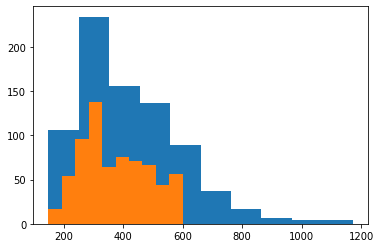

1    248
2    213
0    165
3    164
Name: CEC_, dtype: int64

In [91]:
print(data.CEC_.value_counts())

plt.hist(data.CEC_)
plt.hist(data.loc[data.CEC_<=600, 'CEC_'])
plt.show()

for index, rows in data.iterrows():
    cec = data.at[index, 'CEC_']
    if cec<=280: value = 0
    elif cec>280 and cec<=400: value = 1
    elif cec>400 and cec<=550: value = 2
    elif cec>550: value = 3
    
    data.at[index, 'CEC_'] = value

data.CEC_ = data.CEC_.astype(int)

ranges['CEC_'] = {0:(149,280),1:(280,400),2:(400,550),3:(550,1200)}
data.CEC_.value_counts()

In [92]:
cold_water_cons_mode = data['Cold Wat Cons'].value_counts().index[1]
print('mode of cold_wat_cons - ', cold_water_cons_mode)
mean = data['Cold Wat Cons'].mean()
std = data['Cold Wat Cons'].std()
null_count = data['Cold Wat Cons'].isnull().sum()
null_random = np.random.randint(mean - std, mean + std, size=null_count)
data['Cold Wat Cons'][np.isnan(data['Cold Wat Cons'])] = null_random
data['Cold Wat Cons'] = data['Cold Wat Cons'].astype(int)

for index, row in data.iterrows():
    cold_wat_cons = data.at[index, 'Cold Wat Cons']
    if cold_wat_cons>=0 and cold_wat_cons<50: value = 0
    elif cold_wat_cons>=50 and cold_wat_cons<80: value = 1
    elif cold_wat_cons>=80: value = 2
    data.at[index, 'Cold Wat Cons'] = value

ranges['Cold Wat Cons'] = {0:(0,50),1:(50,80),2:(80,265)}
    
print(data['Cold Wat Cons'].value_counts())

mode of cold_wat_cons -  60.0
2    304
1    282
0    204
Name: Cold Wat Cons, dtype: int64


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


mode of combination -  False


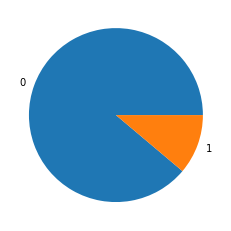

In [93]:
combination_mode = data.Combination.value_counts().index[0]
print('mode of combination - ', combination_mode)
data.Combination = data.Combination.fillna(0)
for index, row in data.iterrows():
    if not data.at[index, 'Combination']:
        data.at[index, 'Combination'] = 0
    else: 
        data.at[index, 'Combination'] = 1

data['Combination'] = data['Combination'].astype(int)
data['Combination'].value_counts()
plt.pie(data.Combination.value_counts(), labels=data.Combination.value_counts().index)
plt.show()

mode of delayStartMode -  True


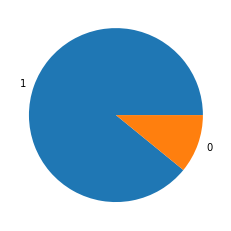

In [94]:
delayStart_mode = data.delayStartMode.value_counts().index[0]
print('mode of delayStartMode - ', delayStart_mode)
data.delayStartMode = data.delayStartMode.fillna(0)
for index, row in data.iterrows():
    if not data.at[index, 'delayStartMode']:
        data.at[index, 'delayStartMode'] = 0
    else: 
        data.at[index, 'delayStartMode'] = 1

data['delayStartMode'] = data['delayStartMode'].astype(int)
data['delayStartMode'].value_counts()

ranges['delayStartMode'] = {0: ['False'], 1:['True']}

plt.pie(data.delayStartMode.value_counts(), labels=data.delayStartMode.value_counts().index)
plt.show()

565.0    48
595.0    24
560.0    19
625.0    18
600.0    16
580.0    14
545.0    13
610.0    13
700.0    13
730.0    11
540.0    11
636.0    11
470.0     9
530.0     9
550.0     9
721.0     9
605.0     8
645.0     7
562.0     7
582.0     7
670.0     6
495.0     6
512.0     6
520.0     6
535.0     6
640.0     6
650.0     5
590.0     5
585.0     4
626.0     4
         ..
624.0     3
620.0     2
696.0     2
448.0     2
616.0     2
536.0     2
695.0     2
767.0     2
537.0     2
643.0     2
542.0     2
850.0     2
606.0     2
658.0     2
686.0     2
505.0     1
634.0     1
611.0     1
525.0     1
557.0     1
675.0     1
714.0     1
660.0     1
510.0     1
400.0     1
517.0     1
950.0     1
555.0     1
835.0     1
637.0     1
Name: Depth, Length: 72, dtype: int64


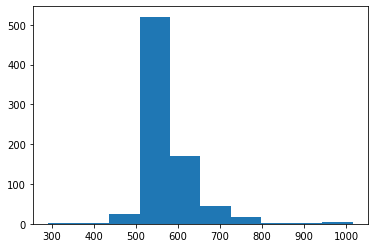

1    397
2    204
0    138
3     51
Name: Depth, dtype: int64

In [95]:
depth_mode = data['Depth'].value_counts().index[0]
print(data.Depth.value_counts())
data.Depth = data.Depth.fillna(0)
for index, row in data.iterrows():
    if int(data.at[index, 'Depth']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Depth'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Depth'].mode().values[0])
        if brand_country_mode!=0:
            depth = brand_country_mode
        elif country_mode!=0:
            depth = country_mode
        else: 
            depth = depth_mode
    else: 
        depth = int(data.at[index, 'Depth'])
    
    data.at[index, 'Depth'] = depth
    
plt.hist(data.Depth)
plt.show()

data.Depth = data.Depth.astype(int)
for index, rows in data.iterrows():
    depth = data.at[index, 'Depth']
    if depth>=292 and depth<565: value = 0
    elif depth==565: value = 1
    elif depth>=570 and depth<700: value = 2
    elif depth>=700: value = 3
        
    data.at[index, 'Depth'] = value
    
data.Depth = data.Depth.astype(int)
data.Depth.value_counts()

mode is - Drum


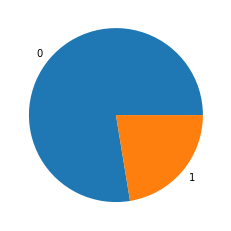

In [96]:
mode_detergentType = data.DetergentType.value_counts().index[0]
print('mode is -', mode_detergentType)
data.DetergentType = data.DetergentType.fillna(mode_detergentType)
for index, row in data.iterrows():
    if data.at[index, 'DetergentType'] == 'Drum':
        value = 0
    else: value = 1
    data.at[index, 'DetergentType'] = value

data.DetergentType = data.DetergentType.astype(int)
data.DetergentType.value_counts()
plt.pie(data.DetergentType.value_counts(), labels=data.DetergentType.value_counts().index)
plt.show()

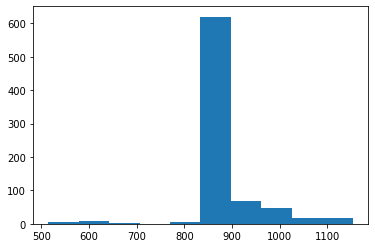

1    551
2    154
0     85
Name: Height, dtype: int64

In [97]:
height_mode = data['Height'].value_counts().index[0]
# print(data.Height.value_counts())
data.Height = data.Height.fillna(0)
for index, row in data.iterrows():
    if int(data.at[index, 'Height']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Height'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Height'].mode().values[0])
        if brand_country_mode!=0:
            height = brand_country_mode
        elif country_mode!=0:
            height = country_mode
        else: 
            height = height_mode
    else: 
        height = int(data.at[index, 'Height'])
    
    data.at[index, 'Height'] = height

plt.hist(data.Height)
plt.show()

for index, row in data.iterrows():
    height = data.at[index, 'Height']
    if height>=515 and height<850: value = 0
    elif height==850: value = 1
    else: value = 2
    data.at[index, 'Height'] = value
    
data.Height = data.Height.astype(int)
data.Height.value_counts()

Yes on the warm wash program only              456
No                                             278
Yes on both the warm and cold wash programs     48
Name: internal_heater, dtype: int64


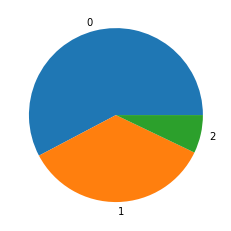

In [98]:
mode_internal_heater = data.internal_heater.value_counts().index[0]
print(data.internal_heater.value_counts())
data.internal_heater.fillna(mode_internal_heater)
for index, rows in data.iterrows():
    if data.at[index, 'internal_heater']=='Yes on the warm wash program only':
        value = 0
    elif data.at[index, 'internal_heater']=='No':
        value = 1
    else: value = 2
    data.at[index, 'internal_heater'] = value

data.internal_heater = data.internal_heater.astype(int)
data.internal_heater.value_counts()
plt.pie(data.internal_heater.value_counts(), labels=data.internal_heater.value_counts().index)
plt.show()

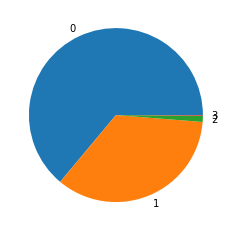

In [99]:
mode_loading = data.Loading.value_counts().index[0]
data.Loading = data.Loading.fillna(mode_loading)

data.Loading = data.Loading.map({'Front':0, 'Top':1, 'Twin Tub':2, 'dual drum, front load':3}).astype(int)
data.Loading.value_counts()

plt.pie(data.Loading.value_counts(), labels=data.Loading.value_counts().index)
plt.show()

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


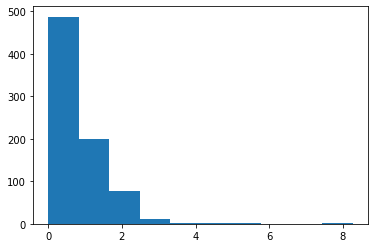

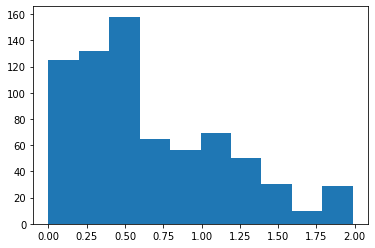

0    272
1    202
2    191
3    125
Name: powerConsMode, dtype: int64

In [100]:
# As we can see the data is mostly between 0 and 2 hence we shall find the count 
# between the range to get a better idea
plt.hist(data.powerConsMode)
plt.show()

plt.hist(data.loc[data['powerConsMode']<2, 'powerConsMode'])
plt.show()

data.powerConsMode = data.powerConsMode.fillna(0.0)
for index, rows in data.iterrows():
    powerConsMode = data.at[index, 'powerConsMode']   
    if powerConsMode<=0.4: value = 0
    elif powerConsMode>0.4 and powerConsMode<=0.75: value = 1
    elif powerConsMode>0.75 and powerConsMode<=1.4: value = 2
    elif powerConsMode>1.4: value = 3
    
    data.at[index, 'powerConsMode'] = value
    
data.powerConsMode = data.powerConsMode.astype(int)

ranges['powerConsMode'] = {0:(0,0.4),1:(0.4,0.75),2:(0.75,1.4),3:(1.4,8)}

data.powerConsMode.value_counts()

0 ['warm', 'cold', 'large', 'normal', 'wash']
1 ['cotton', 'no', '4', '40c']
2 ['cotton', 'no3', '40', 'c']
3 ['no', '2', '40', 'c']
4 ['warm', 'wash']
5 ['warm', 'wash']
6 ['p3']
7 ['program', '1', 'temp', '90', 'c']
8 ['normal', '40', 'degree']
9 ['normal', '40', 'degree']
10 ['normal', '40', 'degree']
11 ['normal', '40', 'degree']
12 ['p7', 'whites', 'medium', 'water', 'level', 'warm', 'temperature', 'program']
13 ['p8', 'whites', 'medium', 'water', 'level', 'warm', 'temperature', 'program']
14 ['p8', 'whites', 'medium', 'water', 'level', 'warm', 'temperature', 'program']
15 ['p8', 'whites', 'medium', 'water', 'level', 'warm', 'temperature', 'program']
16 ['cotton', 'standard', '40']
17 ['cotton', '60c', '1200rpm']
18 ['cottons', 'eco;', '40°c;', '1400rpm']
19 ['normal', 'hot', '&', 'cold', 'water', 'level', '4']
20 ['prog', '1', 'cottons', '60', '1200rpm']
21 ['prog', '1', 'cottons', '60', '1200rpm']
22 ['prog', '1', 'cottons', '60', '1200rpm']
23 ['prog', '2', 'cottons', '60', '12

739 ['warm', 'wash']
740 ['warm', 'wash']
741 ['cotton', 'eco']
742 ['cotton', '&', 'temp.', '60°c', '&', 'spin', 'speed', '1200']
743 ["'cotton", "60'", 'with', 'spin', 'speed', '1600', 'r', 'min']
744 ['e', 'cotton', '40°c', 'intensive', 'rinse', '2', '1400', 'rpm']
745 ['e', 'cotton', '40°c', 'intensive', 'rinse', '2', '1400', 'rpm']
746 ['e', 'cotton', '40°c', 'intensive', 'rinse', '2', '1400', 'rpm']
747 ['‘cotton', '60’', 'with', 'spin', 'speed', '1200', 'r', 'min']
748 ['e', 'cotton', 'temp', '40', 'rinse', '2', 'spin', '1400', 'intensive']
749 ['warm', 'wash']
750 ['warm', 'wash']
751 ['warm', 'wash']
752 ['warm', 'wash']
753 ['standard', 'cotton', '&', 'temp', '60c', '&', 'spin', 'speed', '1200']
754 ['standard', 'cotton', '&', 'temp', '60c', '&', 'spin', 'speed', '1200']
755 ['standard', 'cotton', '&', 'temp', '60c', '&', 'spin', 'speed', '1200']
756 ['standard', 'cotton', '&', 'temp', '60c', '&', 'spin', 'speed', '1200']
757 ['cottons', '60', 'degrees', 'c', 'eco', '1400', '

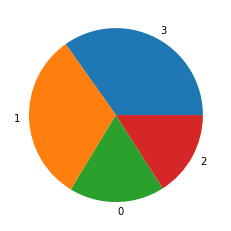

In [101]:
# data['Prog Name'].value_counts()
def return_features(data, index):
    program = data.at[index, 'Prog Name']
    if isinstance(program, float): return []
    if '/' in program:
        types = program.split('/')
        program = ''
        for t in types:
            program+=t+' '
    if ',' in program:
        types = program.split(',')
        program = ''
        for t in types:
            program+=t+' '
    keywords = program.split(' ')
    features = []
    for i in keywords: 
        i = i.strip()
        if i not in ['', '-']: features.append(i.lower())
    print(index, features)
    return features

# General categories - Normal, Heavy, Eco
for index, row in data.iterrows():
    names = return_features(data, index)
    if 'normal' in names: value = 0
    elif 'eco' in names: value = 1
    elif 'cotton' in names: value = 2
    else: value = 3
    
    data.at[index, 'Prog Name'] = value

data['Prog Name'] = data['Prog Name'].astype(int)
data['Prog Name'].value_counts()
plt.pie(data['Prog Name'].value_counts(), labels=data['Prog Name'].value_counts().index)
plt.show()

mode of standby power -  0.5


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


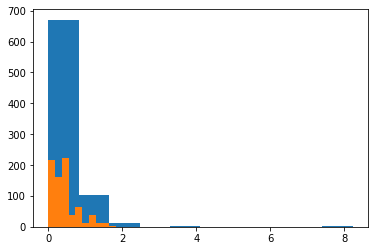

0.00000    80
0.50000    40
0.10000    27
0.20000    24
1.10000    21
0.46000    20
0.38000    18
0.31000    17
0.30000    17
0.79000    16
0.33000    16
0.47000    14
0.17000    14
0.28000    14
1.53000    12
0.48000    12
0.13000    12
0.45000    11
0.44000    11
0.86000    11
0.15000    11
1.13000    11
0.29300    10
0.10800    10
0.25000     9
0.88000     9
0.01000     9
0.51000     8
0.05000     8
0.06000     8
           ..
1.39000     1
0.00700     1
0.66000     1
0.89000     1
0.22500     1
0.22580     1
1.02000     1
0.35700     1
0.58000     1
0.27820     1
0.33100     1
0.70000     1
0.10363     1
0.31930     1
2.06000     1
0.87000     1
0.69000     1
0.72000     1
1.34000     1
0.47100     1
0.34700     1
8.23000     1
0.32200     1
0.38400     1
0.26670     1
0.49100     1
0.12400     1
0.13538     1
0.18020     1
0.45800     1
Name: standbyPowerUsage, Length: 169, dtype: int64
1    308
0    271
2    211
Name: standbyPowerUsage, dtype: int64


In [102]:
mode_standby_power = data.standbyPowerUsage.value_counts().index[1]
print('mode of standby power - ', mode_standby_power)
mean = data.standbyPowerUsage.mean()
std = data.standbyPowerUsage.std()
null_count = data.standbyPowerUsage.isnull().sum()
null_random = np.random.randint(mean - std, mean + std, size=null_count)
data.standbyPowerUsage[np.isnan(data.standbyPowerUsage)] = null_random

plt.hist(data.standbyPowerUsage)
plt.hist(data.loc[data.standbyPowerUsage<2, 'standbyPowerUsage'])
plt.show()

print(data.standbyPowerUsage.value_counts())
# print(data['Active Standby Power'].min(), data['Active Standby Power'].max())
for index, rows in data.iterrows():
    standby_power = data.at[index, 'standbyPowerUsage']
    
    if standby_power<=0.25: value = 0
    elif standby_power>0.25 and standby_power<=0.5: value = 1
    elif standby_power>0.5 : value = 2

    data.at[index, 'standbyPowerUsage'] = value

data.standbyPowerUsage = data.standbyPowerUsage.astype(int)

ranges['standbyPowerUsage'] = {0:(0,0.25),1:(0.25,0.5),2:(0.5,8)}
print(data.standbyPowerUsage.value_counts())

595.0    131
600.0     91
601.0     25
550.0     23
597.0     14
596.0     14
690.0     11
686.0     11
540.0     11
545.0      8
605.0      7
580.0      6
870.0      6
520.0      6
530.0      5
632.0      5
525.0      5
620.0      4
640.0      3
590.0      3
902.0      2
761.0      2
560.0      2
718.0      2
645.0      2
570.0      2
526.0      2
685.0      2
700.0      2
593.0      1
840.0      1
660.0      1
585.0      1
510.0      1
581.0      1
665.0      1
515.0      1
Name: Width, dtype: int64


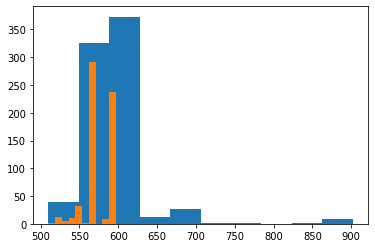

0    355
1    247
2    188
Name: Width, dtype: int64

In [103]:
width_mode = data['Width'].value_counts().index[0]
print(data.Width.value_counts())
data.Width = data.Width.fillna(0)
for index, row in data.iterrows():
    if int(data.at[index, 'Width']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Width'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Width'].mode().values[0])
        if brand_country_mode!=0:
            width = brand_country_mode
        elif country_mode!=0:
            width = country_mode
        else: 
            width = depth_mode
    else: 
        width = int(data.at[index, 'Width'])
    
    data.at[index, 'Width'] = width
    
plt.hist(data.Width)
plt.hist(data.loc[data.Width<600, 'Width'])
plt.show()

data.Depth = data.Depth.astype(int)
for index, rows in data.iterrows():
    width = data.at[index, 'Width']
    if width<=565: value = 0
    elif width>=570 and width<600: value = 1
    elif width>=600: value = 2

    data.at[index, 'Width'] = value

data.Width = data.Width.astype(int)
data.Width.value_counts()

In [104]:
# As we can see we have successfully removed all the missing values
# we still have to convert several columns into integer classes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 23 columns):
ApplStandard         790 non-null object
Brand                790 non-null object
Cap                  790 non-null float64
CEC Cold             790 non-null int64
CEC_                 790 non-null int64
Cold Wat Cons        790 non-null int64
Combination          790 non-null int64
Conn_Mode            790 non-null object
Country              790 non-null object
delayStartMode       790 non-null int64
Depth                790 non-null int64
DetergentType        790 non-null int64
Height               790 non-null int64
internal_heater      790 non-null int64
Loading              790 non-null int64
New Star             790 non-null float64
powerConsMode        790 non-null int64
Prog Name            790 non-null int64
standbyPowerUsage    790 non-null int64
Type                 790 non-null object
Width                790 non-null int64
Program Time         790 non-null float64
Bran

In [105]:
# As we can see we have removed all the null values are removed, now we must convert all the other data type
# to int type, by mapping boolean and objects to int
ApplStandard_types = {'AS/NZS 2040.2:2005': 0, 'AS/NZS 2040.2:2005 (Legacy)': 1, 'AS/NZS 2040.2:2000 (Legacy)': 2, 'Greenhouse and Energy Minimum Standards (Clothes Washing Machines) Determination 2015': 3, 'Greenhouse and Energy Minimum Standards (Clothes Washing Machines) Determination 2012': 4}
data['ApplStandard'] = data['ApplStandard'].map(ApplStandard_types).astype(int)
data['Conn_Mode'] = data['Conn_Mode'].map({'Dual':0, 'Cold': 1}).astype(int)
data['Type'] = data['Type'].map({'Drum':0, 'Non-Drum': 1}).astype(int)

ranges['Conn_Mode'] = {0:['Dual'],1:['Cold']}
ranges['Type'] = {0:['Drum'],1:['Non-Drum']}

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 23 columns):
ApplStandard         790 non-null int64
Brand                790 non-null object
Cap                  790 non-null float64
CEC Cold             790 non-null int64
CEC_                 790 non-null int64
Cold Wat Cons        790 non-null int64
Combination          790 non-null int64
Conn_Mode            790 non-null int64
Country              790 non-null object
delayStartMode       790 non-null int64
Depth                790 non-null int64
DetergentType        790 non-null int64
Height               790 non-null int64
internal_heater      790 non-null int64
Loading              790 non-null int64
New Star             790 non-null float64
powerConsMode        790 non-null int64
Prog Name            790 non-null int64
standbyPowerUsage    790 non-null int64
Type                 790 non-null int64
Width                790 non-null int64
Program Time         790 non-null float64
Brand_C

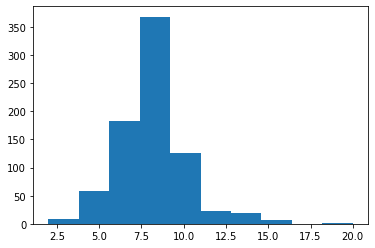

8.0     146
7.0     111
10.0    101
9.0      79
7.5      73
8.5      70
6.0      51
5.5      35
9.5      24
6.5      21
5.0      20
11.0     11
12.0     11
13.0     10
14.0      9
16.0      5
2.0       4
2.5       3
4.5       2
3.0       1
15.0      1
4.0       1
20.0      1
Name: Cap, dtype: int64


3    252
2    216
1    184
0    138
Name: Cap, dtype: int64

In [106]:
plt.hist(data.Cap)
plt.show()
print(data.Cap.value_counts())

for index, row in data.iterrows():
    cap = data.at[index, 'Cap']
    if cap<7: value = 0
    elif cap>=7 and cap<8: value = 1
    elif cap>=8 and cap<9: value = 2
    else: value = 3
    
    data.at[index, 'Cap'] = value

data.Cap = data.Cap.astype(int)

ranges['Cap'] = {0:(2,7),1:(7,8),2:(8,9),3:(9,20)}

data.Cap.value_counts()

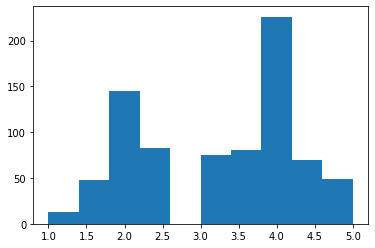

4.0    226
2.0    145
2.5     83
3.5     81
3.0     75
4.5     70
5.0     49
1.5     48
1.0     13
Name: New Star, dtype: int64


2    345
1    239
0    206
Name: New Star, dtype: int64

In [107]:
plt.hist(data['New Star'])
plt.show()

print(data['New Star'].value_counts())
for index, rows in data.iterrows():
    star = data.at[index, 'New Star']
    if star<=2: value = 0
    elif star>2 and star<4: value = 1
    else: value = 2

    data.at[index, 'New Star'] = value

data['New Star'] = data['New Star'].astype(int)
data['New Star'].value_counts()

186.00    15
192.00    14
232.00    13
300.00    13
240.00    12
134.91    11
150.00    11
257.00    11
118.00    10
366.00     9
258.00     8
68.00      8
60.00      8
58.00      8
275.00     7
248.00     7
228.00     7
62.00      7
89.00      7
230.40     6
238.00     6
90.00      6
425.00     6
87.00      6
244.00     6
45.00      6
77.00      6
231.00     6
266.00     6
210.00     5
          ..
42.00      1
106.00     1
115.00     1
204.00     1
0.00       1
230.00     1
344.00     1
349.00     1
241.64     1
179.00     1
242.84     1
341.00     1
455.75     1
248.22     1
67.20      1
197.52     1
141.40     1
242.33     1
237.60     1
65.90      1
323.00     1
244.53     1
89.38      1
181.70     1
237.87     1
306.76     1
265.39     1
216.58     1
148.77     1
351.00     1
Name: Program Time, Length: 285, dtype: int64


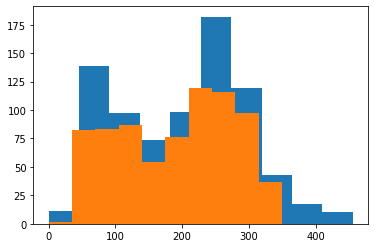

1    298
2    275
0    217
Name: Program Time, dtype: int64


In [108]:
print(data['Program Time'].value_counts())

plt.hist(data['Program Time'])
plt.hist(data.loc[data['Program Time']<350, 'Program Time'])
plt.show()

for index, rows in data.iterrows():
    time = data.at[index, 'Program Time']
    
    if time<=125: value = 0
    elif time>125 and time<250: value = 1
    else: value = 2
    
    data.at[index, 'Program Time'] = value

data['Program Time'] = data['Program Time'].astype(int)

ranges['Program Time'] = {0:(20,125),1:(125,250),2:(250,500)}

print(data['Program Time'].value_counts())

In [109]:
# We have converted all the initial types into integer type
# For now we shall not consider the effects of Brand_country, Brand and Country
data.drop(['Brand_Country', 'Brand', 'Country'], axis=1, inplace=True)
data.head(3)

,ApplStandard,Cap,CEC Cold,CEC_,Cold Wat Cons,Combination,Conn_Mode,delayStartMode,Depth,DetergentType,Height,internal_heater,Loading,New Star,powerConsMode,Prog Name,standbyPowerUsage,Type,Width,Program Time
0,2,0,1,2,2,0,0,0,1,0,1,2,1,0,0,0,0,1,0,0
1,2,0,3,0,1,0,0,0,1,0,1,2,0,1,0,2,0,0,0,0
2,2,0,3,0,1,0,0,0,1,0,1,2,0,1,0,2,0,0,0,1


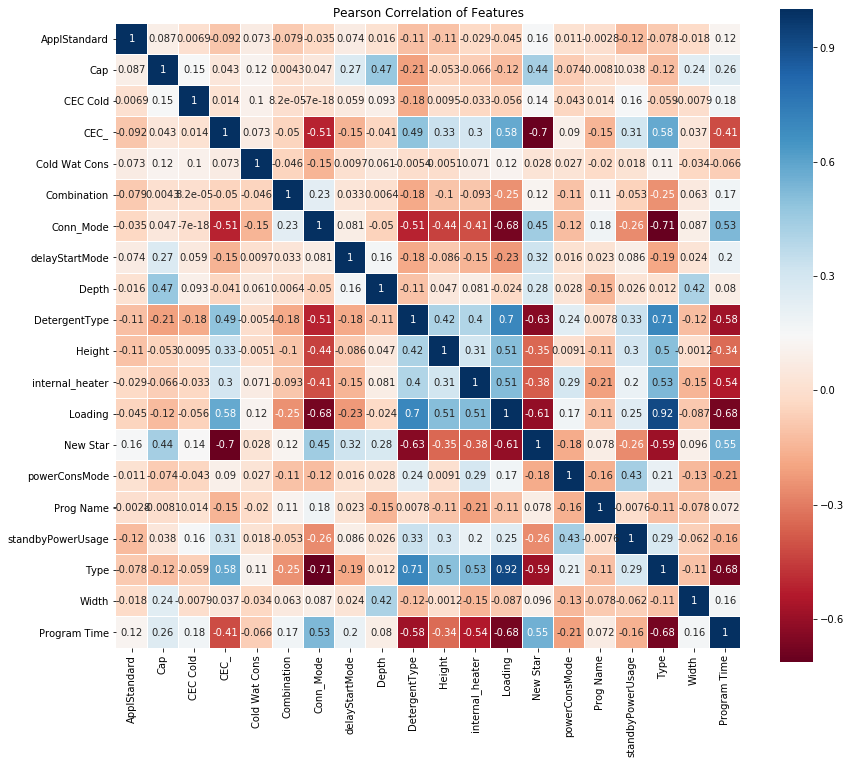

In [110]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, annot=True)

In [111]:
# As we can see, the features Loading, Type and DetergentType are highly correlated with each other, so we can drop one of them 
# to reduce redundancy. 
columns = ['Loading', 'DetergentType']

# We can also remove the features which are really poorly correlated with New Star
columns+=['ApplStandard','CEC Cold','Cold Wat Cons','Combination','Prog Name','Width', 'Depth', 'Height', 'powerConsMode']

data.drop(columns, axis=1, inplace=True)
data.head(3)

,Cap,CEC_,Conn_Mode,delayStartMode,internal_heater,New Star,standbyPowerUsage,Type,Program Time
0,0,2,0,0,2,0,0,1,0
1,0,0,0,0,2,1,0,0,0
2,0,0,0,0,2,1,0,0,1


In [112]:
problemFeatures = []
allFeatures = list(data.columns)
allFeatures.remove('New Star')
for feature in allFeatures:
    if abs(data[feature].corr(data['New Star']))>0.3:
        print(feature)
        problemFeatures.append(feature)

Cap
CEC_
Conn_Mode
delayStartMode
internal_heater
Type
Program Time


In [113]:
train_x = data.drop('New Star', axis=1)
train_y = data['New Star']
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)

train_y

337    2
577    2
222    1
90     2
409    1
79     0
50     2
741    1
292    0
404    0
300    0
692    2
310    0
768    2
487    2
662    1
711    1
650    2
239    1
49     2
602    2
78     0
150    2
667    2
458    1
622    2
28     0
130    1
260    2
44     2
      ..
217    0
666    2
660    1
781    0
25     1
764    0
469    2
479    2
155    0
82     1
47     2
156    1
93     0
307    2
97     1
121    1
788    1
120    0
69     1
306    2
494    1
747    1
193    2
767    2
206    2
651    2
17     1
432    2
547    1
503    0
Name: New Star, Length: 632, dtype: int64

In [114]:
# KNN Neighbours Classification
knn = KNeighborsClassifier(n_neighbors = 3, leaf_size=5, algorithm='auto')
knn.fit(train_x, train_y)  
knn_predictions = knn.predict(train_x)  
knn_accuracy = round(knn.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(train_y, knn_predictions, average=None))
print("Recall score: ", recall_score(train_y, knn_predictions, average=None))
print("F Score: ", f1_score(train_y, knn_predictions, average=None))

# Since we are getting a reasonably good score, we can tune this classifier

Accuracy:  92.41
Precision score:  [0.90751445 0.8839779  0.96043165]
Recall score:  [0.93452381 0.85561497 0.96389892]
F Score:  [0.92082111 0.86956522 0.96216216]


In [115]:
knn = KNeighborsClassifier(n_neighbors = 3, leaf_size=5, algorithm='ball_tree')
knn.fit(test_x, test_y)  
knn_predictions = knn.predict(test_x)  
knn_accuracy = round(knn.score(test_x, test_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(test_y, knn_predictions, average=None))
print("Recall score: ", recall_score(test_y, knn_predictions, average=None))
print("F Score: ", f1_score(test_y, knn_predictions, average=None))

Accuracy:  87.34
Precision score:  [0.8974359  0.85106383 0.875     ]
Recall score:  [0.92105263 0.76923077 0.92647059]
F Score:  [0.90909091 0.80808081 0.9       ]


In [116]:
joblib.dump(knn, '../server/weights/washing_machine_weight.sav')

['../server/weights/washing_machine_weight.sav']

In [117]:
specifications_for_0 = {}
for feature in problemFeatures:
    specifications_for_0[feature] = list(data.loc[data['New Star']==0, feature].value_counts().index[:1])
print(specifications_for_0)

ranges['specifications_for_0'] = specifications_for_0

{'Cap': [0], 'CEC_': [3], 'Conn_Mode': [0], 'delayStartMode': [1], 'internal_heater': [1], 'Type': [1], 'Program Time': [0]}


In [118]:
specifications_for_1 = {}
for feature in problemFeatures:
    specifications_for_1[feature] = list(data.loc[data['New Star']==1, feature].value_counts().index[:1])
print(specifications_for_1)

ranges['specifications_for_1'] = specifications_for_1

{'Cap': [3], 'CEC_': [2], 'Conn_Mode': [0], 'delayStartMode': [1], 'internal_heater': [0], 'Type': [0], 'Program Time': [1]}


In [119]:
specifications_for_2 = {}
for feature in problemFeatures:
    specifications_for_2[feature] = list(data.loc[data['New Star']==2, feature].value_counts().index[:1])
print(specifications_for_2)

ranges['specifications_for_2'] = specifications_for_2

{'Cap': [2], 'CEC_': [1], 'Conn_Mode': [1], 'delayStartMode': [1], 'internal_heater': [0], 'Type': [0], 'Program Time': [2]}


In [120]:
# file = open('../server/inferences/data_ranges/washing_machine.json','w')
# json.dump(ranges,file)